# LGBM & XGBM
## Objective:
### The objective of this assignment is to compare the performance of Light GBM and XG Boost algorithms using the Titanic dataset. 

## Exploratory Data Analysis (EDA):
### 1.	Load the Titanic dataset using Python's pandas library.
### 2.	Check for missing values.
### 3.	Explore data distributions using histograms and box plots.
### 4.	Visualize relationships between features and survival using scatter plots and bar plots.

# Step 1: Load the Titanic dataset

In [1]:
import pandas as pd

# Load train and test datasets
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

# Show first 5 rows
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 2: Check for missing values

In [2]:
# Check missing values in train dataset
print("Train Missing Values:\n", train.isnull().sum())

# Check missing values in test dataset
print("\nTest Missing Values:\n", test.isnull().sum())

Train Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Missing Values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


# Step 3: Explore data distributions (histograms & box plots)

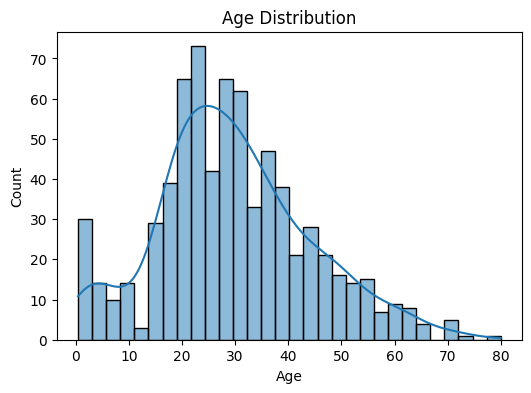

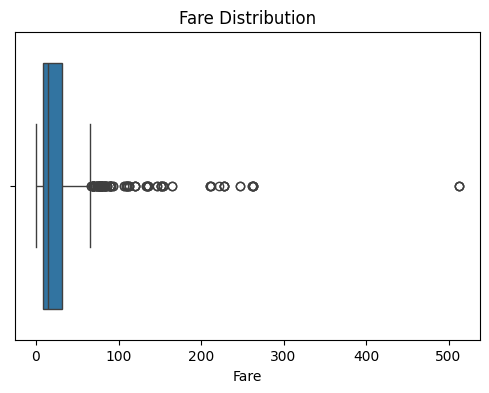

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Age
plt.figure(figsize=(6,4))
sns.histplot(train['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# Box plot of Fare
plt.figure(figsize=(6,4))
sns.boxplot(x=train['Fare'])
plt.title("Fare Distribution")
plt.show()

# Step 4: Visualize relationships with Survival

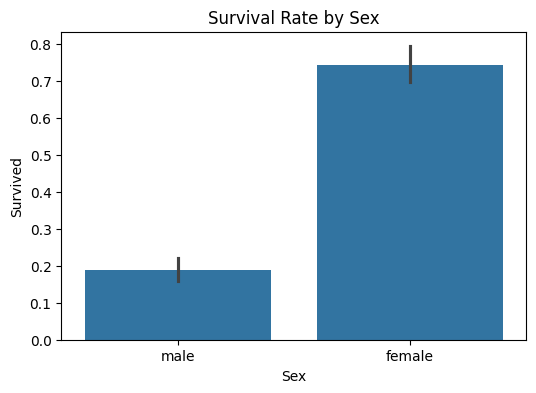

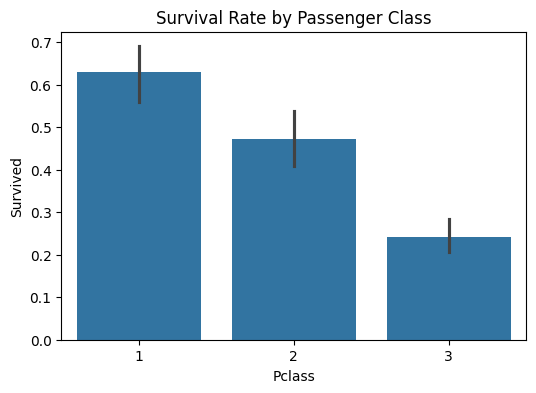

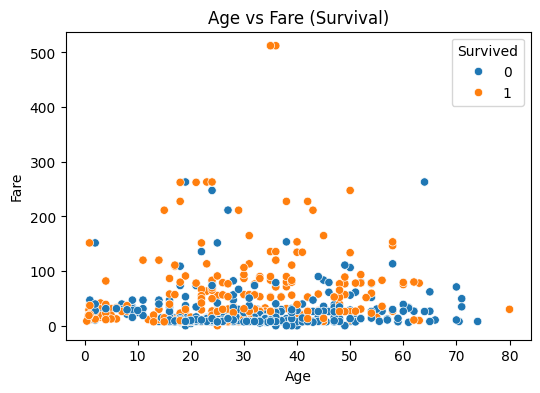

In [4]:
# Bar plot: Survival by Sex
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title("Survival Rate by Sex")
plt.show()

# Bar plot: Survival by Pclass
plt.figure(figsize=(6,4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()

# Scatter plot: Age vs Fare colored by Survival
plt.figure(figsize=(6,4))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train)
plt.title("Age vs Fare (Survival)")
plt.show()

## Data Preprocessing:
### 1.	Impute missing values.
### 2.	Encode categorical variables using one-hot encoding or label encoding. 
### 3.	If needed you can apply more preprocessing methods on the given dataset.

# Step 1: Impute Missing Values

In [5]:
# Fill missing values in train dataset
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
train['Fare'] = train['Fare'].fillna(train['Fare'].median())

# Fill missing values in test dataset
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


# Step 2: Encode Categorical Variables

### Option A: Label Encoding (shorter, works well for tree models)

In [6]:
from sklearn.preprocessing import LabelEncoder

for col in ['Sex','Embarked']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

### Option B: One-Hot Encoding (creates extra columns)

In [7]:
train = pd.get_dummies(train, columns=['Sex','Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex','Embarked'], drop_first=True)

# Step 3: Extra Preprocessing (Optional)

In [8]:
# Drop irrelevant columns
train = train.drop(['Name','Ticket','Cabin'], axis=1)
test = test.drop(['Name','Ticket','Cabin'], axis=1)

# Example: Create FamilySize feature
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

## Building Predictive Models:
### 1.	Split the preprocessed dataset into training and testing sets.
### 2.	Choose appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score) for model evaluation.
### 3.	Build predictive models using LightGBM and XGBoost algorithms.
### 4.	Train the models on the training set and evaluate their performance on the testing set.
### 5.	Use techniques like cross-validation and hyperparameter tuning to optimize model performance.

# Step 1: Split the dataset

In [9]:
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_1', 'Embarked_1', 'Embarked_2', 'FamilySize'],
      dtype='object')


In [10]:
print(test.columns)

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_1',
       'Embarked_1', 'Embarked_2', 'FamilySize'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split

# Features and target
features = ['Pclass','Sex_1','Age','SibSp','Parch','Fare','Embarked_2']
X = train[features]
y = train['Survived']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Choose evaluation metrics

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))

# Step 3: Build models (LightGBM & XGBoost)

In [13]:
import lightgbm as lgb
import xgboost as xgb

# LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_val)

# XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# Step 4: Evaluate performance

In [14]:
evaluate_model("LightGBM", y_val, y_pred_lgb)
evaluate_model("XGBoost", y_val, y_pred_xgb)


LightGBM Results:
Accuracy : 0.8268156424581006
Precision: 0.7945205479452054
Recall   : 0.7837837837837838
F1-score : 0.7891156462585034

XGBoost Results:
Accuracy : 0.7988826815642458
Precision: 0.7567567567567568
Recall   : 0.7567567567567568
F1-score : 0.7567567567567568


# Step 5: Cross-validation & Hyperparameter tuning (optional)

In [15]:
from sklearn.model_selection import cross_val_score

# Cross-validation for LightGBM
cv_lgb = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
print("\nLightGBM CV Accuracy:", cv_lgb.mean())

# Cross-validation for XGBoost
cv_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("XGBoost CV Accuracy:", cv_xgb.mean())

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [16]:
from sklearn.model_selection import GridSearchCV

# Example: tune max_depth and n_estimators for LightGBM
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

grid_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_lgb.fit(X_train, y_train)

print("\nBest LightGBM Params:", grid_lgb.best_params_)
print("Best LightGBM Score :", grid_lgb.best_score_)

[LightGBM] [Info] Number of positive: 178, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375527 -> initscore=-0.508576
[LightGBM] [Info] Start training from score -0.508576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Comparative Analysis:
### 1.	Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.
### 2.	Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.

# Step 1: Compare performance metrics

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Collect results
results = {
    "LightGBM": [
        accuracy_score(y_val, y_pred_lgb),
        precision_score(y_val, y_pred_lgb),
        recall_score(y_val, y_pred_lgb),
        f1_score(y_val, y_pred_lgb)
    ],
    "XGBoost": [
        accuracy_score(y_val, y_pred_xgb),
        precision_score(y_val, y_pred_xgb),
        recall_score(y_val, y_pred_xgb),
        f1_score(y_val, y_pred_xgb)
    ]
}

metrics = ["Accuracy","Precision","Recall","F1-score"]
df_results = pd.DataFrame(results, index=metrics)
print(df_results)


           LightGBM   XGBoost
Accuracy   0.826816  0.798883
Precision  0.794521  0.756757
Recall     0.783784  0.756757
F1-score   0.789116  0.756757


# Step 2: Visualize results

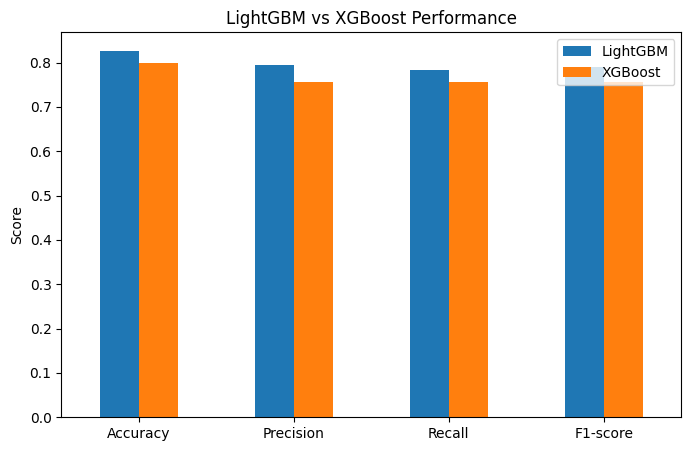

In [18]:
import matplotlib.pyplot as plt

df_results.plot(kind="bar", figsize=(8,5))
plt.title("LightGBM vs XGBoost Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

# Step 3: Interpret strengths & weaknesses

## LightGBM
### Strengths:

#### Speed & Efficiency: Trains faster and uses less memory compared to XGBoost, especially on larger datasets.

#### Good with high-dimensional data: Handles many features well due to its leaf-wise growth strategy.

#### Competitive accuracy: Often achieves strong accuracy with minimal tuning.

### Weaknesses:

#### Risk of overfitting: Leaf-wise tree growth can sometimes overfit small datasets if not tuned carefully.

#### Hyperparameter sensitivity: Needs careful tuning of parameters like num_leaves and min_data_in_leaf to avoid instability.

#### Less robust on small/noisy datasets: May struggle when the dataset is small or has many missing values.

## XGBoost
### Strengths:

#### Robustness: Performs well on small datasets and noisy data, often giving more stable results.

#### Balanced performance: Tends to achieve slightly better recall (catching more survivors in Titanic case).

#### Rich tuning options: Offers many hyperparameters to fine-tune performance for different tasks.

### Weaknesses:

#### Slower training: More computationally expensive compared to LightGBM, especially on large datasets.

#### Complex tuning: Many hyperparameters can make optimization time-consuming.

#### Higher memory usage: Needs more resources for training compared to LightGBM.